# Get graph embeddings from GraphSage output

In [7]:
%matplotlib notebook
import graph_tool
import snap
import numpy as np
from pymongo import MongoClient, GEOSPHERE
from matplotlib import pylab as plt
import operator
from IPython.display import HTML, display
import tabulate
from scipy import stats
import collections
from os import path

In [8]:
# Database client

client = MongoClient('localhost', 27272)
db = client.test
business = db.business
reviews = db.review
users = db.users

In [9]:
top_cities = [u'Las Vegas',
 u'Phoenix',
 u'Toronto',
 u'Charlotte',
 u'Scottsdale',
 u'Calgary',
 u'Pittsburgh',
 u'Mesa',
 u'Montr\xe9al',
 u'Henderson']

dir_format = '/yagami/lyl/project/GraphSAGE/unsup-GraphSAGE_input/{}_graphsage_mean_small_0.000010'

## Get Graph Embeddings for each cascade graph

In [68]:
business_ids = list(db.city_business.find(
        {},
        {
            '_id': 0,
            'business_id': 1
        }
    ))

In [69]:
embedding_graph = {}

for i, business in enumerate(business_ids):
    business_id = business['business_id']
    dir_name = dir_format.format(business_id)
    val_npy_loc = path.join(dir_name, 'val.npy')
    if not path.exists(val_npy_loc):
        continue
    embedding_mat = np.load(val_npy_loc)
    
    embedding_avg = np.average(embedding_mat, axis=0)
    embedding_sum = np.sum(embedding_mat, axis=0)
    embedding = np.concatenate((embedding_sum, embedding_avg, ))  # [embedding_mat.shape[0], ]
    embedding_graph[business_id] = embedding

In [70]:
len(embedding_graph)

11631

## Get business popularity score from database

In [71]:
import json 

def business_id_list(path):
    id_list = []
    i = 0
    with open(path, 'r') as f:
        for line in f:
            i += 1
            id_list.append(line[:-1])
            # if i > 8000:
            #     break
    return id_list

business_ids = business_id_list('GraphSAGE_input/bid.txt')
business_ranking = json.load(open('business-ranking.json'))

In [72]:
def popularity_score(rank, neighbors):
    return np.power(float(rank) / neighbors, 1)

In [73]:
# create a n x m dimensional matrix of embedding & value

x = []
y = []
for i, business in enumerate(business_ids):
    business_id = business
    if business_id in embedding_graph and business_id in business_ranking:
        rank, neighbors = business_ranking[business_id]['rank'], business_ranking[business_id]['neighbors']
        x.append(embedding_graph[business_id])
        y.append(popularity_score(rank, neighbors))
x, y = np.array(x), np.array(y)

In [74]:
x.shape

(11631, 40)

In [75]:
n, m = x.shape  # n = number of test data, m = dimension

In [76]:
indices = np.random.permutation(n)
offset_train, offset_dev, offset_test = 0, int(n * 0.6), int(n * 0.8)
train, dev, test = indices[offset_train : offset_dev], indices[offset_dev : offset_test], indices[offset_test :]

x_train, x_dev, x_test = x[train, :], x[dev, :], x[test, :]
y_train, y_dev, y_test = y[train], y[dev], y[test]

In [77]:
y_test

array([0.2085041 , 0.13656148, 0.03      , ..., 0.29230769, 0.00497512,
       0.21428571])

## Regression

In [78]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [89]:
for count, degree in enumerate([2, 3, 4]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(solver='svd'))
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    accuracy = np.sum(y_test == y_test_output)
    print y_dev.shape, accuracy

(2286,) 0


KeyboardInterrupt: 

In [ ]:
np.sum((y_test < 0.1) == (y_test_output < 0.1))

In [ ]:
np.sum((y_test < 0.1))

In [ ]:
np.sum(np.logical_and((y_test_output < 0.1), (y_test < 0.1)))

In [ ]:
np.sum(y_test_output < 0.1)

In [53]:
best_r2, best_model = 0, None

In [79]:
for i in range(20):
    mlp = MLPRegressor(hidden_layer_sizes=(200, 300, 200, 50), activation='relu', solver='adam', alpha=0.0001, verbose=False)
    mlp.out_activation_ = 'sigmoid'
    model = make_pipeline(mlp)
    model.fit(x_train, y_train)
    y_test_output = model.predict(x_test)
    r2 = r2_score_result(y_test, y_test_output)
    print r2
    if r2 > best_r2:
        best_r2, best_model = r2, model

r2 score is 0.322296
0.32229561781179006
r2 score is 0.296195
0.29619459619992505
r2 score is 0.244300
0.24429986188736807
r2 score is 0.434985
0.43498530605196173
r2 score is 0.370551
0.3705514542135022
r2 score is 0.476046
0.4760459712787357
r2 score is -1.246772
-1.2467717545646844
r2 score is 0.074607
0.07460745120227374
r2 score is 0.257058
0.2570584127832708
r2 score is 0.149970
0.14996987504223258
r2 score is 0.419583
0.419583118141704
r2 score is 0.457498
0.45749818345596993
r2 score is 0.423253
0.42325328125976924
r2 score is 0.269943
0.26994290893709716
r2 score is 0.413924
0.41392428665425907
r2 score is 0.429009
0.42900881666554325
r2 score is 0.361257
0.3612565472560323
r2 score is 0.264031
0.264030815341209
r2 score is 0.347471
0.3474711268993368
r2 score is 0.321571
0.3215706799358876


In [54]:
def plot_regress_viz(ground_truth, prediction, filename=None):
    plt.figure()
    plt.scatter(ground_truth, prediction, alpha=0.5, s= 5)
    reference_line = np.array([0, 0.5, 1])
    plt.plot(reference_line, reference_line, '--', color='grey')
    plt.xlabel('ground truth')
    plt.ylabel('prediction')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

def r2_score_result(ground_truth, prediction):
    s = r2_score(ground_truth, prediction)
    print 'r2 score is %f' % s
    return s

<IPython.core.display.Javascript object>


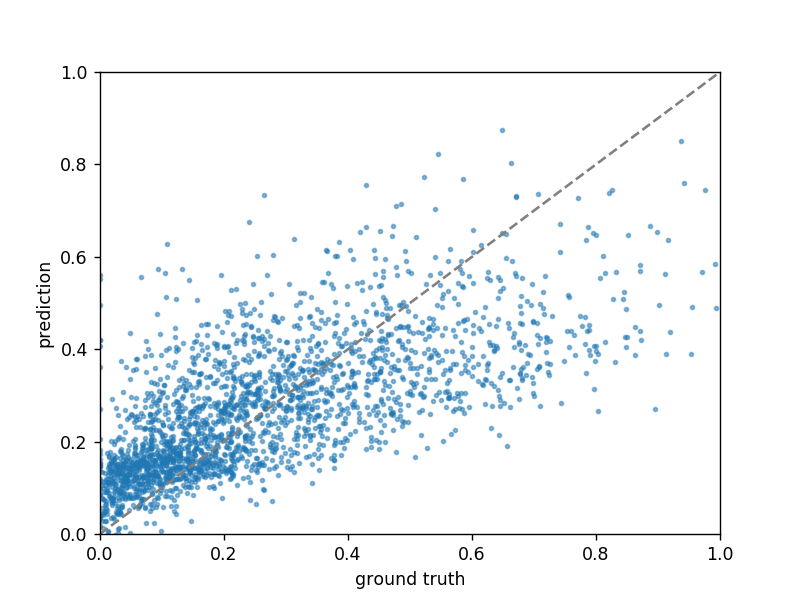

In [81]:
model = model_40d
y_test_output = model.predict(x_test)
plot_regress_viz(y_test, y_test_output, 'r2_40d.pdf')

In [91]:
print r2_score_result(y_test, y_test_output)

r2 score is -0.007009
-0.007009200935606419


In [80]:
r2_40d, model_40d = best_r2, best_model

In [47]:
r2_20d_sum, model_20d_sum = best_r2, best_model

In [60]:
r2_20d_sum

0.4412238559049725

In [62]:
r2_20d_avg, model_20d_avg = best_r2, best_model

In [38]:
r2_20d_num, model_20d_num= best_r2, best_model